In [2]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/data')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

Mounted at /content/gdrive


In [3]:
df = pd.read_csv('hmeq.csv')
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Hầu hết đều là biến numeric, chỉ có `JOB` và `REASON` là category

**Thống kê mô tả**

In [5]:
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


Trung bình thấp nhất là 0.254570 và cao nhất là 101776.048741	
Có dữ liệu missing 

**Phân phối của các biến**

In [6]:
numeric_cols = df.select_dtypes(include=['float','int']).columns

In [7]:
numeric_cols

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

Number of numeric field: 11
Error CLNO


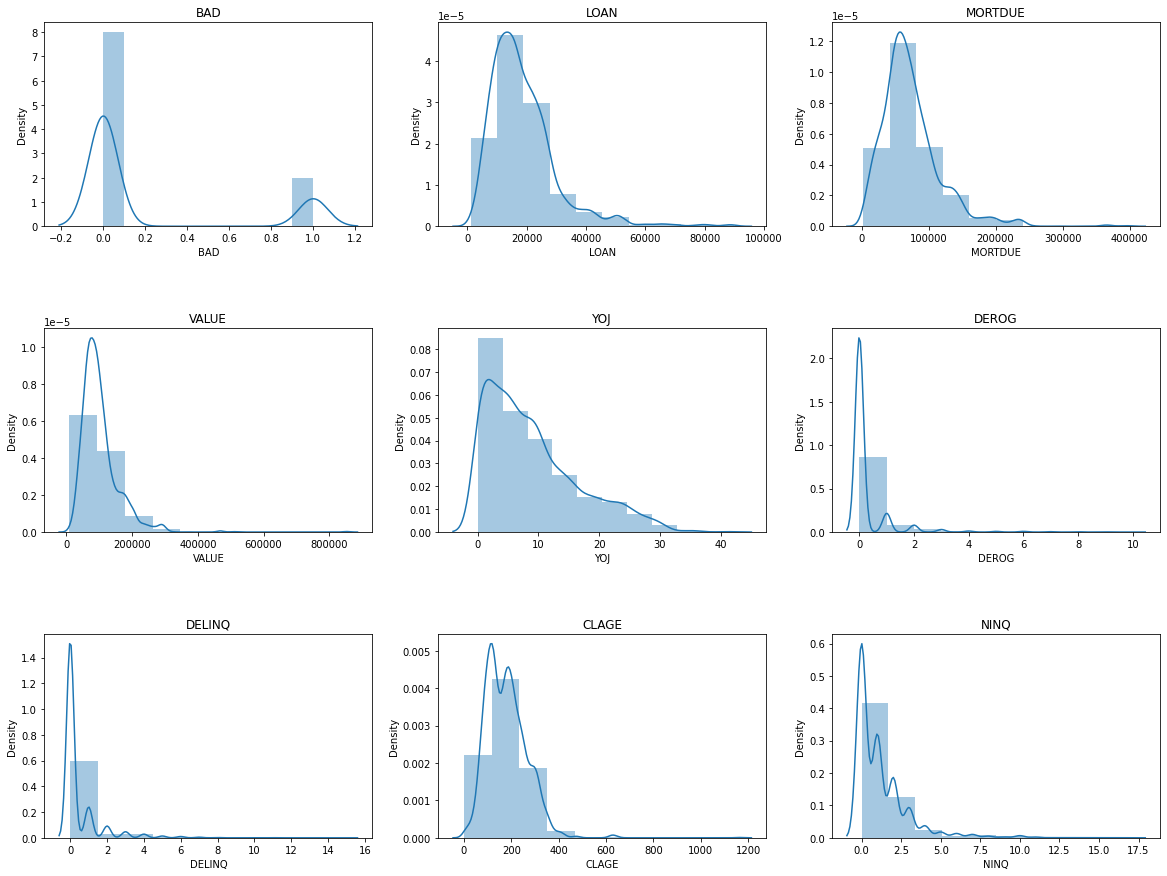

In [16]:
import warnings
warnings.filterwarnings('ignore')

def plot_numeric_classes(df, col, bins=10, hist=True, kde= True):
  sns.distplot(df[col],
                  bins=bins,
                  hist=hist,
                  kde=kde)

def distribution_numeric(df, numeric_cols, row=3, col=3, figsize=(20,15), bins=10):
  print('Number of numeric field:', len(numeric_cols))
  assert row*(col-1) < len(numeric_cols)
  plt.figure(figsize=figsize)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
  for i in range(1, len(numeric_cols)+1,1):
    try:
      plt.subplot(row, col, i)
      plot_numeric_classes(df, numeric_cols[i-1], bins=bins)
      plt.title(numeric_cols[i-1])
    except:
      print('Error {}'.format(numeric_cols[i-1]))
      break
      
distribution_numeric(df, numeric_cols)

Hầu hết các biến có dạng phân phối lệch phải

number of category field:  2


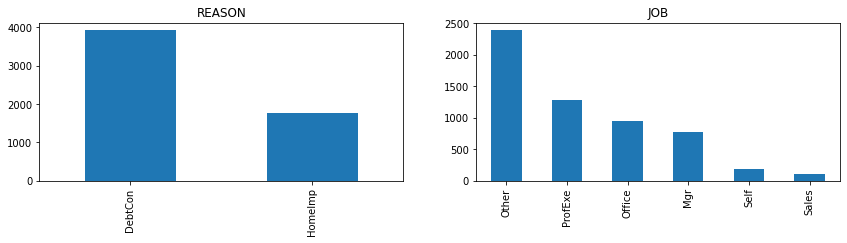

In [22]:
# Đối với biến phân loại
cate_cols = df.select_dtypes('O').columns

def plot_bar_classes(df, cols):
    df[cols].value_counts().plot.bar()

def distribution_cate(df, cate_cols, row = 1, col = 2, figsize = (20, 5)):
  print('number of category field: ', len(cate_cols))
  plt.figure(figsize = figsize)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)    
  for i in range(1, len(cate_cols)+1, 1):
    try:
      plt.subplot(row, col, i)
      plot_bar_classes(df, cate_cols[i-1])
      plt.title(cate_cols[i-1])
    except:
      break

distribution_cate(df, cate_cols, row = 4, col = 4, figsize = (30, 16))

## Phân chia train/test

In [24]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify = df['BAD'])
X_train = df_train.copy()
y_train = X_train.pop('BAD')

X_test = df_test.copy()
y_test = X_test.pop('BAD')
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4768, 12) (4768,)
(1192, 12) (1192,)


## Xây dựng pipeline để chuyển dữ liệu thô sang tinh

In [25]:
cat_names = list(X_train.select_dtypes('object').columns)
num_names = list(X_train.select_dtypes(['float', 'int']).columns)

In [26]:
# Pipeline xử lý cho biến phân loại
cat_pl= Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), 
        ('onehot', OneHotEncoder()),
    ]
)

In [27]:
# Pipeline xử lý cho biến liên tục
num_pl = Pipeline(
    steps=[
           ('imputer', KNNImputer(n_neighbors=7)),
           ('scaler', MinMaxScaler()) 
    ]
)

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pl, num_names),
        ('cat', cat_pl, cat_names), 
    ]
)

In [29]:
# Completed training pipeline
completed_pl = Pipeline(
    steps=[
            ("preprocessor", preprocessor), 
            ("classifier", RandomForestClassifier())
    ]
)

# training
completed_pl.fit(X_train, y_train)

# accuracy
y_train_pred = completed_pl.predict(X_train)
print(f'Accuracy on train: {accuracy_score(list(y_train), list(y_train_pred)):.2f}')

y_pred = completed_pl.predict(X_test)
print(f'Accuracy on test: {accuracy_score(list(y_test), list(y_pred)):.2f}')

Accuracy on train: 1.00
Accuracy on test: 0.91


## Cross Validation

In [32]:
def fbeta(y_true, y_pred):
	return fbeta_score(y_true, y_pred, beta=np.sqrt(2))

In [33]:
# Xác định KFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Xác định metric cho mô hình
metric = make_scorer(fbeta)
# Đánh giá mô hình
scores = cross_val_score(completed_pl, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
print('Mean Fbeta: {:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))

Mean Fbeta: 0.675 0.050


## Triển khai trên nhiều mô hình khác nhau

In [34]:
# list các mô hình được lựa chọn
models = [GaussianNB(), LogisticRegression(), KNeighborsClassifier(), MLPClassifier(), RandomForestClassifier()]

# Xác định KFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

all_scores = []
# Đánh giá toàn bộ các mô hình trên tập K-Fold đã chia
for model in models:
  completed_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('classifier', model)]
  )

  scores = cross_val_score(completed_pl, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
  all_scores.append(scores)

## Vẽ biểu đồ thể hiện kết quả các mô hình

Text(0.5, 1.0, 'Scores Metrics')

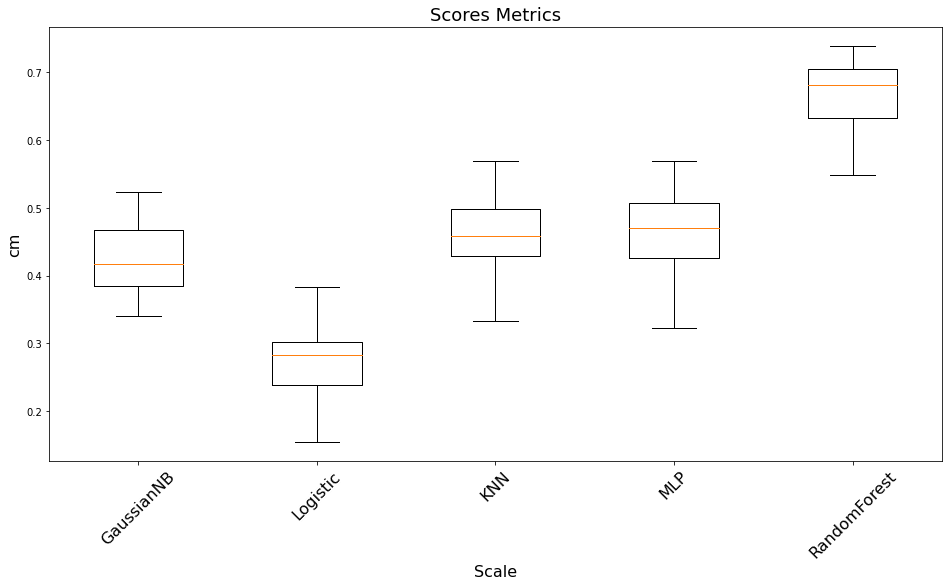

In [35]:
model_names = ['GaussianNB', 'Logistic', 'KNN', 'MLP', 'RandomForest']

# Draw bboxplot 
plt.figure(figsize=(16, 8))
plt.boxplot(all_scores)
plt.xlabel('Scale', fontsize=16)
plt.ylabel('cm', fontsize=16)
plt.xticks(np.arange(len(model_names))+1, model_names, rotation=45, fontsize=16)
plt.title("Scores Metrics", fontsize=18)

Random Forest là thuật toán có độ chính xác cao nhất 

## Grid Search

In [36]:
from sklearn.base import BaseEstimator
class ClassifierSwitcher(BaseEstimator):
  def __init__(
      self, 
      estimator = RandomForestClassifier(),
  ):  
      self.estimator = estimator

  def fit(self, X, y=None, **kwargs):
      self.estimator.fit(X, y)
      return self


  def predict(self, X, y=None):
      return self.estimator.predict(X)


  def predict_proba(self, X):
      return self.estimator.predict_proba(X)


  def score(self, X, y):
      return self.estimator.score(X, y)

In [37]:
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline(
    steps=[("pre", preprocessor), ("clf", ClassifierSwitcher())]
)

In [38]:
parameters = [
    {
        'clf__estimator': [LogisticRegression()], # SVM if hinge loss / logreg if log loss
        'clf__estimator__penalty': ('l2', 'elasticnet', 'l1'),
        'clf__estimator__max_iter': [50, 80],
        'clf__estimator__tol': [1e-4]
    },
    {
        'clf__estimator': [RandomForestClassifier()],
        'clf__estimator__n_estimators': [50, 100],
        'clf__estimator__max_depth': [5, 10],
        'clf__estimator__criterion': ('gini', 'entropy')
    },
]

In [39]:
metric = make_scorer(fbeta)
gscv = GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, scoring=metric, return_train_score=True, error_score=0, verbose=3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, error_score=0,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(n_neighbors=7)),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['LOAN',
                                                                          'MORTDUE',
                                                                          'VALUE',
                                                                          'YOJ',
                                                                          'DEROG

In [40]:
# mô hình tốt nhất
gscv.best_estimator_

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=7)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['LOAN', 'MORTDUE', 'VALUE',
                                                   'YOJ', 'DEROG', 'DELINQ',
                                                   'CLAGE', 'NINQ', 'CLNO',
                                                   'DEBTINC']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                           

In [41]:
# tham số tốt nhất
gscv.best_params_

{'clf__estimator': RandomForestClassifier(max_depth=10, n_estimators=50),
 'clf__estimator__criterion': 'gini',
 'clf__estimator__max_depth': 10,
 'clf__estimator__n_estimators': 50}

In [42]:
gscv.best_score_

0.5196559415498935